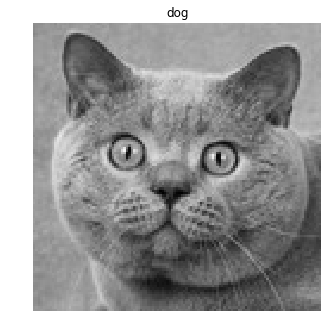

In [227]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import sin, cos, pi, e, atan
from itertools import permutations
from collections import Counter

dog = plt.imread('./cat.jfif')[:, :, :3] / 255
# dog = plt.imread('/home/tongxueqing/zhaox/PythonSkills/ImageProcessing/dog.png')[:, :, :3]
dog = np.mean(dog, axis = 2, keepdims = False)
height, width = dog.shape[:2]

def show(*plots, **kwargs):
    names = []
    dic = globals()
    for plot in plots:
        for key in dic:
            if key.startswith('_'):
                continue
            if dic[key] is plot:
                names.append(key)
    row = round(len(plots) ** 0.5)
    col = round(len(plots) / row)
    fig, axs = plt.subplots(row, col)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.1)
    if isinstance(axs, matplotlib.axes._subplots.Axes):
        if np.max(plots[0]) > 1:
            vmax = 255
        else:
            vmax = 1
        axs.imshow(plots[0], cmap = 'gray', vmin = 0, vmax = vmax)
        if len(names) > 0:
            axs.set_title(names[0])
        axs.axis('off')
    else:
        for i, ax in enumerate(axs.flatten()):
            if i < len(plots):
                if np.max(plots[i]) > 1:
                    vmax = 255
                else:
                    vmax = 1
                ax.imshow(plots[i], cmap = 'gray', vmin = 0, vmax = vmax)
                if i < len(names):
                    ax.set_title(names[i])
            ax.axis('off')
    plt.show()
    
def hist(*plots, **kwargs):
    names = []
    dic = globals()
    for i, plot in enumerate(plots):
        for key in dic:
            if key.startswith('_'):
                continue
            if dic[key] is plot:
                names.append(key)
        if i == len(names):
            names.append('')
    plt.hist([plot.flatten() for plot in plots], label = names, **kwargs)
    plt.legend()
    plt.show()
    
def norm(dog, vmin, vmax):
    dog = (vmax - vmin) * (dog - np.min(dog)) / np.ptp(dog) + vmin
    return dog

def delta(A):
    h, w = A.shape
    ret = np.array([[(-1) ** (i + j) for j in range(w)] for i in range(h)])
    return ret
    
show(dog)

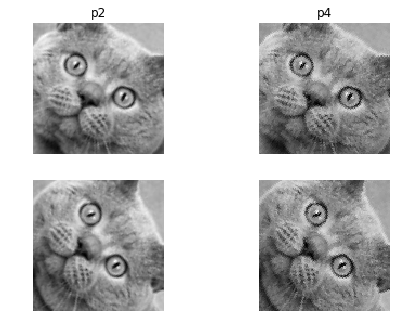

In [145]:
# 旋转， 内插（最近邻，双线性）
def insertVal(xy, dog, mode = '4'):
    x, y = xy
    xi = int(x)
    yi = int(y)
    if mode == '4':
        if x % 1 == 0 and y % 1 == 0:
            return dog[xi, yi]
        elif x % 1 == 0:
            yi1 = yi + 1
            return (y - yi) * (dog[xi, yi1] - dog[xi, yi]) + dog[xi, yi]
        elif y % 1 == 0:
            xi1 = xi + 1
            return (x - xi) * (dog[xi1, yi] - dog[xi, yi]) + dog[xi, yi]
        else:
            A = np.array([[i, j, i * j, 1] for i in (xi, xi + 1) for j in (yi, yi + 1) if i < len(dog) and j < len(dog[0])])
            b = np.array([dog[i, j] for i, j in A[:, :2].tolist()])
            X = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), b)
            return np.dot([x, y, x * y, 1], X)
    if mode == '1':
        if x % 1 == 0 and y % 1 == 0:
            return dog[xi, yi]
        elif x % 1 == 0:
            return dog[xi, yi] if y - yi < 0.5 else dog[xi, yi + 1]
        elif y % 1 == 0:
            return dog[xi, yi] if x - xi < 0.5 else dog[xi + 1, yi]
        else:
            xi = xi if x - xi < 0.5 else xi + 1
            yi = yi if y - yi < 0.5 else yi + 1
            return dog[xi, yi]
        
def rot(dog, angle, mode = '4'):
    height, width = dog.shape[:2]
    mapping = np.array([[np.dot(rotate(angle).T, np.reshape([v, w, 1], 3, 1))[:2] for w in range(width)] for v in range(height)])
    mapping[:, :, 0] = (height - 1) * (mapping[:, :, 0] - np.min(mapping[:, :, 0])) / np.ptp(mapping[:, :, 0])
    mapping[:, :, 1] = (width - 1) * (mapping[:, :, 1] - np.min(mapping[:, :, 1])) / np.ptp(mapping[:, :, 1])
    out = np.apply_along_axis(insertVal, 2, mapping, dog, mode)
    return out

rotate = lambda a: np.array([[cos(a), sin(a), 0], [-sin(a), cos(a), 0], [0, 0, 1]])

p1 = rot(dog, pi / 6)
p2 = rot(dog, pi / 6, mode = '1')
p3 = rot(dog, pi / 3)
p4 = rot(dog, pi / 3, mode = '1')

show(norm(p1, 0, 1), p2, norm(p3, 0, 1), p4)

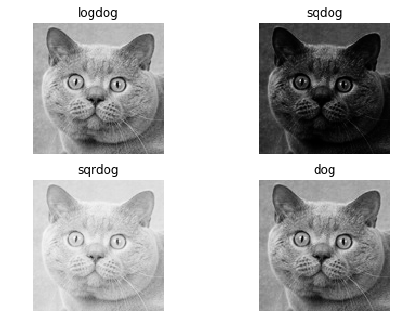

In [146]:
logdog = np.log2(dog + 1)
sqdog = dog ** 3        # 伽马变换
sqrdog = dog ** (1 / 3) # 伽马变换 
show(logdog, sqdog, sqrdog, dog)

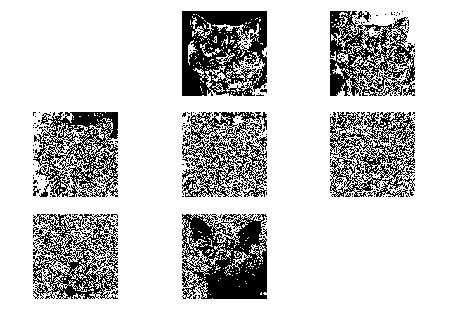

In [147]:
# 比特分层
def getlayer(string, i):
    return eval(string[2 + i])

def binint(x):
    string = bin(np.int(x))[:10]
    if len(string) < 10:
        string = string + '0' * (10 - len(string))
    return string
        
getlayer = np.vectorize(getlayer)
binint = np.vectorize(binint)
vecEval = np.vectorize(eval)

bindog = np.round(255 * dog)
bindog = binint(bindog)
show(*[getlayer(bindog, l) for l in range(8)])

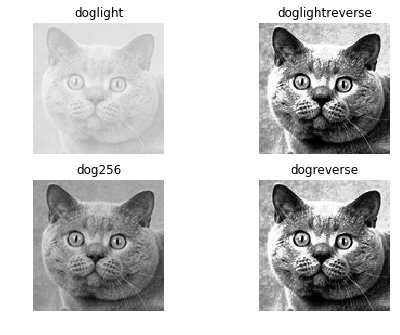

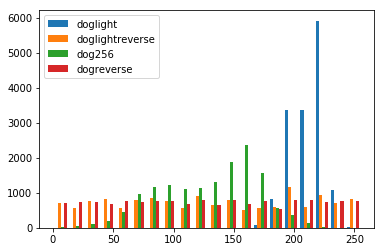

In [148]:
#直方图匹配
def transform(dog):
    sums = Counter(dog.flatten())
    func = np.vectorize(lambda i: 255 * sum(sums[j] for j in range(int(i) + 1)) / (width * height))
    return func(dog)

dog256 = np.round(255 * dog)
doglight = np.round((dog256 + 2 * 255) / 3)
doglightreverse = transform(doglight)
dogreverse = transform(dog256)
show(doglight, doglightreverse, dog256, dogreverse)
hist(doglight, doglightreverse, dog256, dogreverse, bins = 20)

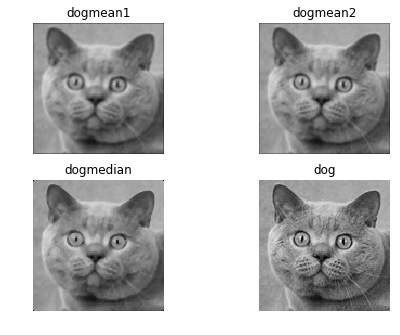

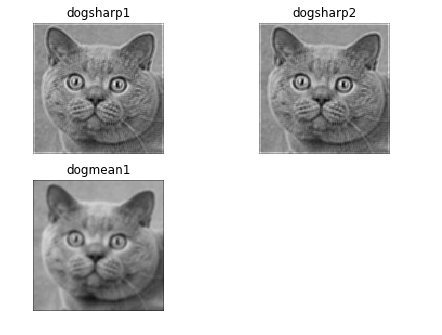

In [253]:
# 空间滤波
def pad(dog, p):
    new = np.zeros((dog.shape[0] + 2 * p, dog.shape[1] + 2 * p))
    new[p:-p, p:-p] = dog
    return new

def conv(dog, w = None, f = None, mode = 'mean'):
    if mode == 'mean':
        f = w.shape[0]
    p = (f - 1) // 2
    pdog = pad(dog, p)
    new = np.zeros(dog.shape)
    for i in range(len(new)):
        for j in range(len(new[0])):
            if mode == 'mean':
                new[i, j] = np.sum(w * pdog[i:i + f, j:j + f])
            elif mode == 'median':
                new[i, j] = np.median(pdog[i:i + f, j:j + f])
    return new

def sharp(dog, w):
    return norm(dog + norm(conv(dog, w), 0, 1), 0, 1)

# 平滑空间滤波器
w1 = np.ones((3, 3)) / 9
w2 = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
dogmean1 = conv(dog, w1)
dogmean2 = conv(dog, w2)
dogmedian = conv(dog, f = 3, mode = 'median')
show(dogmean1, dogmean2, dogmedian, dog)

#锐化空间滤波器
w3 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
w4 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
dogsharp1 = sharp(dogmean1, w3)
dogsharp2 = sharp(dogmean1, w4)
show(dogsharp1, dogsharp2, dogmean1)

In [87]:
def ft(dog, center = False):
    height, width = dog.shape
    if center:
        newdog = dog * delta(dog)
    else:
        newdog = dog
    F = np.zeros((height, width), dtype = np.complex128)
    for u in range(height):
        for v in range(width):
            F[u, v] = np.sum([
                newdog[x, y] * e ** (-2j * pi * (u * x / height + v * y / width)) 
                for x in range(height) for y in range(width)
            ])
    return F

def spec(F):
    getReal = np.vectorize(lambda F: F.real)
    getImag = np.vectorize(lambda F: F.imag)
    R = getReal(F)
    I = getImag(F)
    Fabs = np.sqrt(R ** 2 + I ** 2)
    return Fabs

F = ft(dog)
Fcenter = ft(dog, True)

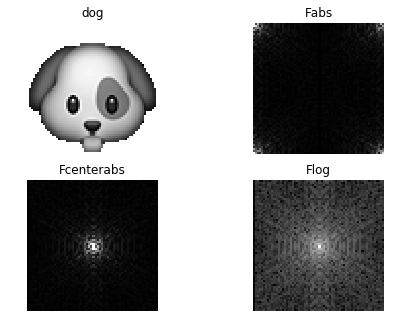

In [100]:
Fabs = spec(F)
Fcenterabs = spec(Fcenter)
Flog = norm(np.log(Fcenterabs + 1), 0, 1)

show(dog, Fabs, Fcenterabs, Flog)

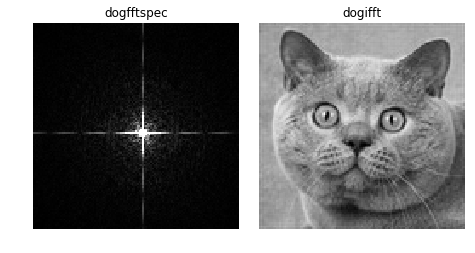

In [232]:
# 快速傅里叶变换
def fft(A):
    M = len(A)
    n = np.log2(M)
    if n % 1 != 0:
        n = int(n) + 1
        M = 2 ** n
        newA = np.zeros(M, dtype = np.complex128)
        newA[:len(A)] = A[:]
    else:
        newA = A[:]
    if M == 1:
        return A
    wn = e ** (-2j * pi / M)
    w = 1
    Aeven = [newA[i] for i in range(M) if i % 2 == 0]
    Aodd = [newA[i] for i in range(M) if i % 2 == 1]
    Feven = fft(Aeven)
    Fodd = fft(Aodd)
    F = np.zeros(M, dtype = np.complex128)
    for i in range(M // 2):
        F[i] = Feven[i] + w * Fodd[i]
        F[i + M // 2] = Feven[i] - w * Fodd[i]
        w *= wn
    return F[:len(A)]

def ifft(F):
    conj = np.vectorize(lambda F: F.conjugate())
    newF = conj(F)
    f = fft(newF) / len(newF)
    f = conj(f)
    return f

def fft2d(dog, center = False):
    height, width = dog.shape
    if center:
        newdog = dog * delta(dog)
    else:
        newdog = dog
    tmp = np.apply_along_axis(fft, 1, newdog)
    return np.apply_along_axis(fft, 0, tmp)

def ifft2d(dog, center = False):
    conj = np.vectorize(lambda F: F.conjugate())
    getReal = np.vectorize(lambda F: F.real)
    newdog = conj(dog)
    ret = fft2d(newdog, center = center)
    ret = getReal(ret) * delta(ret)
    ret = norm(ret, 0, 1)
    return ret

dogfft = fft2d(dog, True)
dogifft = ifft2d(dogfft)
dogfftspec = spec(dogfft)
show(dogfftspec, dogifft)

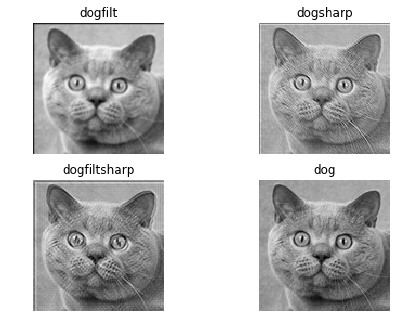

In [251]:
# 频率域滤波
def filt(dog, w):
    height, width = dog.shape
    wh, ww = w.shape
    P = height + wh - 1
    Q = width + ww - 1
    newdog = np.zeros((P, Q))
    neww = np.zeros((P, Q))
    newdog[:height, :width] = dog
    neww[:wh, :ww] = w
    F = fft2d(newdog, center = True)
    H = fft2d(neww, center = True)
    F = F * H
    outdog = ifft2d(F)
    outdog = outdog[:height, :width]
    return outdog

w = np.array([[1, 2, 1], [2, 8, 2], [1, 2, 1]]) / 16
w2 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
dogfilt = filt(dog, w)
dogsharp = norm(dog + filt(dog, w2), 0, 1)
dogfiltsharp = norm(dog + filt(dogfilt, w2), 0, 1)
show(dogfilt, dogsharp, dogfiltsharp, dog)

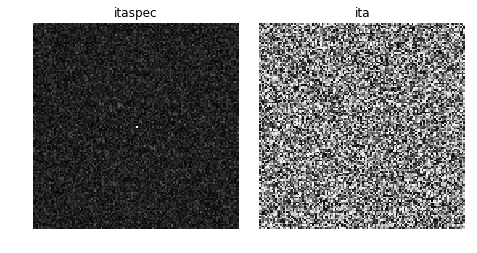

In [264]:
#噪声
ita = np.random.random((128, 128))
Ita = fft2d(ita, True)
itaspec = spec(Ita)
show(itaspec, ita)